In [1]:
from GmGM.synthetic import DatasetGenerator, PrecMatGenerator, PrecMatErdosRenyiGilbert
from GmGM import GmGM
from TeraLasso import TeraLasso
from EiGLasso import EiGLasso

import timeit
from statistics import median
import numpy as np
import matplotlib.pyplot as plt

In [2]:
linestyles = ['-', '--', '-.', ':']

In [3]:
def generate_timing_data_smart(
    algorithms: dict[str, callable],
    sizes: list[int],
    K: int,
    attempts: int, 
    cutoff: int = 60,
    verbose: bool = False
):  
    includes: dict[str, bool] = {}
    times: dict[str, list[float]] = {}
    
    for algorithm in algorithms:
        includes[algorithm]: bool = True
        times[algorithm]: list[float] = []
    for d in sizes:
        if not any(includes.values()):
            if verbose:
                print("All algorithms timed out")
            break
        if verbose:
            print(f"Starting {(d,) * K}")

        # Generate Data
        structure = {
            "dataset_0": tuple(f"axis_{j}" for j in range(K))
        }
        sub_generators = {
            f"axis_{i}": PrecMatGenerator(
                core_type="coreless",
                mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            )
            for i in range(K)
        }
        generator = DatasetGenerator(
            structure=structure,
            generator=sub_generators,
            size={axis: d for axis in structure["dataset_0"]},
        )
        generator.reroll_Psis()
        dataset = generator.generate({"dataset_0": 1})

        # Test algorithms
        for algorithm in algorithms.keys():
            if not includes[algorithm]:
                continue
            times[algorithm].append(0)
            durations = timeit.Timer(
                lambda: algorithms[algorithm](dataset.deepcopy())
            ).repeat(
                repeat=attempts,
                number=1
            )
            times[algorithm][-1] = median(durations)
            if times[algorithm][-1] >= cutoff:
                if verbose:
                    print(f"{algorithm} ran for longer than {cutoff} seconds")
                    print(f"{algorithm} is no longer being tracked")
                includes[algorithm] = False
            else:
                if verbose:
                    print(f"\t{algorithm}: {times[algorithm][-1]} Seconds")
    print("Done")
    return times

## 2-Axis Runtimes

In [6]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
    "EiGLasso": lambda dataset: EiGLasso(dataset, 0, 0),
}
size_data_2 = [
    # EiGLasso
    100, 125, 150, 175, 200, 225, 250, 275,
    # TeraLasso
    300, 400, 500,
    # GmGM
    600, 700, 800, 900, 1000,
    1100, 1200, 1300, 1400, 1500,
    1750, 2000, 2250, 2500,
    3000, 3500, 4000, 4500, 5000,
    # GmGM-50pc
    6000, 7000, 8000, 9000, 10000,
    11000
]
timing_data_2 = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data_2,
    K=2,
    attempts=1,
    verbose=True
)

Starting (100, 100)
	GmGM: 0.018681708000002573 Seconds
	GmGM-50pc: 0.07627087500000584 Seconds
	TeraLasso: 1.8114159169999908 Seconds
	EiGLasso: 7.632716375000001 Seconds
Starting (125, 125)
	GmGM: 0.02626700000000426 Seconds
	GmGM-50pc: 0.09474245900000255 Seconds
	TeraLasso: 2.239366375000003 Seconds
	EiGLasso: 13.045566417000003 Seconds
Starting (150, 150)
	GmGM: 0.03717554199999995 Seconds
	GmGM-50pc: 0.09058733299998778 Seconds
	TeraLasso: 6.53655225 Seconds
	EiGLasso: 18.137471084000012 Seconds
Starting (175, 175)
	GmGM: 0.05967262500000459 Seconds
	GmGM-50pc: 0.08682295799999906 Seconds
	TeraLasso: 7.040463125000002 Seconds
	EiGLasso: 23.784426874999994 Seconds
Starting (200, 200)
	GmGM: 0.061576292000012245 Seconds
	GmGM-50pc: 0.08345316699998762 Seconds
	TeraLasso: 8.574127333000007 Seconds
	EiGLasso: 31.858677999999998 Seconds
Starting (225, 225)
	GmGM: 0.07849979200000234 Seconds
	GmGM-50pc: 0.08444929200001638 Seconds
	TeraLasso: 10.911251416999988 Seconds
	EiGLasso: 43.88

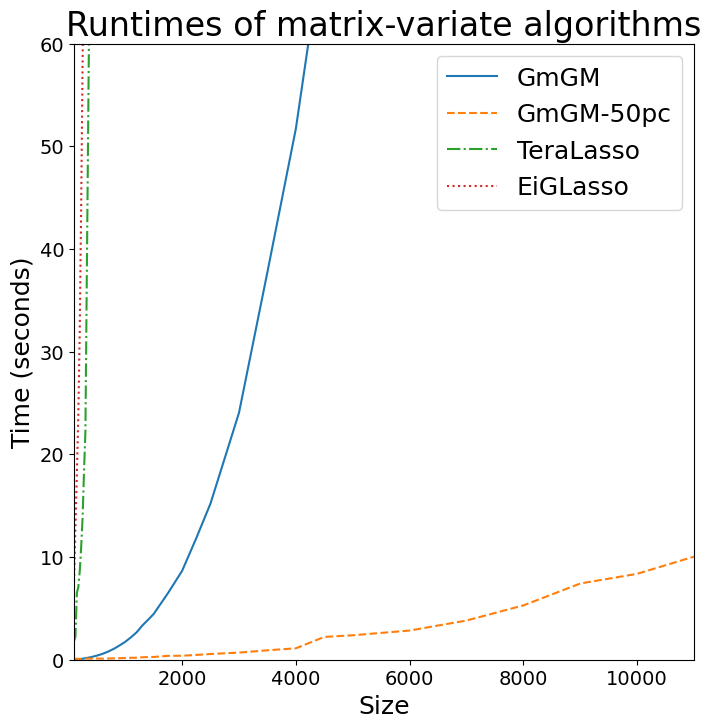

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_2):
    ax.plot(
        size_data_2[:len(timing_data_2[algorithm])],
        timing_data_2[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of matrix-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_2[0], size_data_2[-1]])
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_2.pdf", bbox_inches='tight')

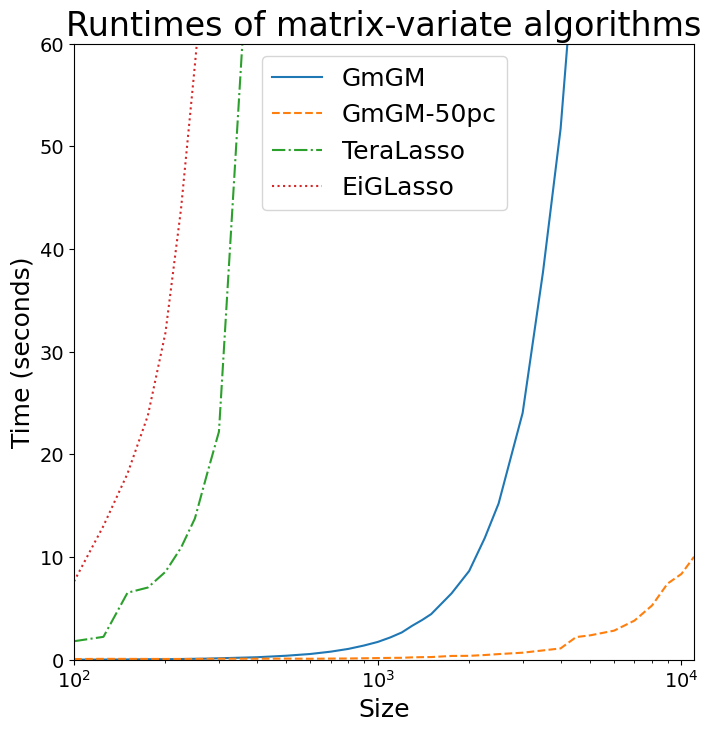

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_2):
    ax.plot(
        size_data_2[:len(timing_data_2[algorithm])],
        timing_data_2[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of matrix-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_2[0], size_data_2[-1]])
ax.set_xscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_2_log.pdf", bbox_inches='tight')

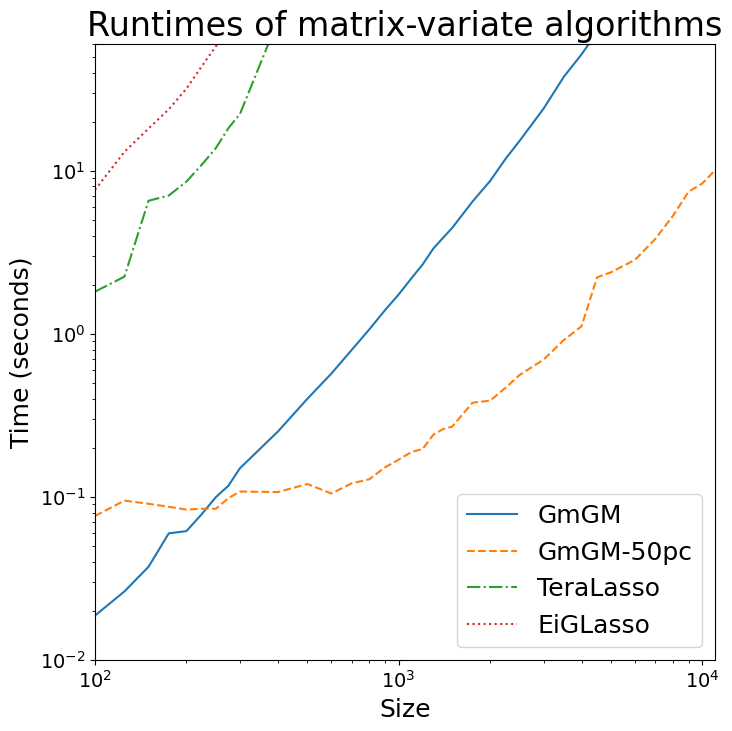

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_2):
    ax.plot(
        size_data_2[:len(timing_data_2[algorithm])],
        timing_data_2[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of matrix-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0.01, 60])
ax.set_xlim([size_data_2[0], size_data_2[-1]])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_2_loglog.pdf", bbox_inches='tight')

## 3-Axis Runtimes

In [10]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
}
size_data_3 = [
    50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,
    160, 170, 180, 190, 200, 250, 300, 350, 400, 450, 500
]
timing_data_3 = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data_3,
    K=3,
    attempts=1,
    verbose=True
)

Starting (50, 50, 50)


	GmGM: 1.13347716699991 Seconds
	GmGM-50pc: 0.16852095800004463 Seconds
	TeraLasso: 4.010844041999917 Seconds
Starting (60, 60, 60)
	GmGM: 0.26633333300014783 Seconds
	GmGM-50pc: 0.17873283399967477 Seconds
	TeraLasso: 0.7706255419998342 Seconds
Starting (70, 70, 70)
	GmGM: 0.4247683329999745 Seconds
	GmGM-50pc: 0.22423908300015682 Seconds
	TeraLasso: 1.200177208000241 Seconds
Starting (80, 80, 80)
	GmGM: 0.6339327089999642 Seconds
	GmGM-50pc: 0.31536995799979195 Seconds
	TeraLasso: 1.6746193330000096 Seconds
Starting (90, 90, 90)
	GmGM: 0.9009140419998403 Seconds
	GmGM-50pc: 0.3724327909999374 Seconds
	TeraLasso: 2.2116702079997594 Seconds
Starting (100, 100, 100)
	GmGM: 1.2324770420000277 Seconds
	GmGM-50pc: 0.43588099999988117 Seconds
	TeraLasso: 2.963836791000176 Seconds
Starting (110, 110, 110)
	GmGM: 1.627220832999683 Seconds
	GmGM-50pc: 0.6180732090001584 Seconds
	TeraLasso: 3.600046624999777 Seconds
Starting (120, 120, 120)
	GmGM: 2.0961804170001415 Seconds
	GmGM-50pc: 0.819313

/Users/baileyandrew/mambaforge/envs/GmGM-python-accelerate/lib/python3.9/site-packages/GmGM/core/core.py:409: RuntimeWarning: invalid value encountered in scalar divide
  if err_diff/np.abs(err) < tol or line_search_gave_up:


	GmGM-50pc: 16.579103292000127 Seconds
Starting (450, 450, 450)
	GmGM-50pc: 22.86038445899976 Seconds
Starting (500, 500, 500)
	GmGM-50pc: 34.66853654200031 Seconds
Done


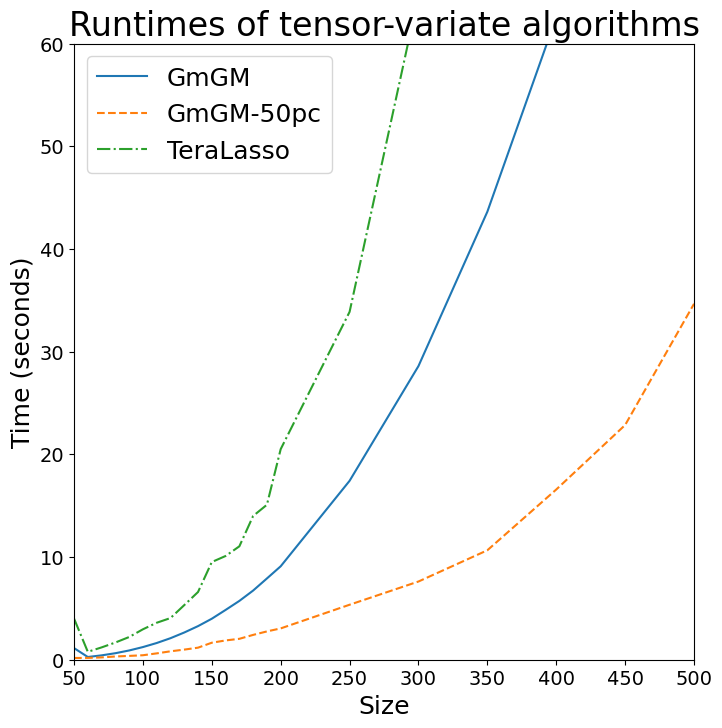

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_3):
    ax.plot(
        size_data_3[:len(timing_data_3[algorithm])],
        timing_data_3[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of tensor-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_3[0], size_data_3[-1]])
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_3.pdf", bbox_inches='tight')

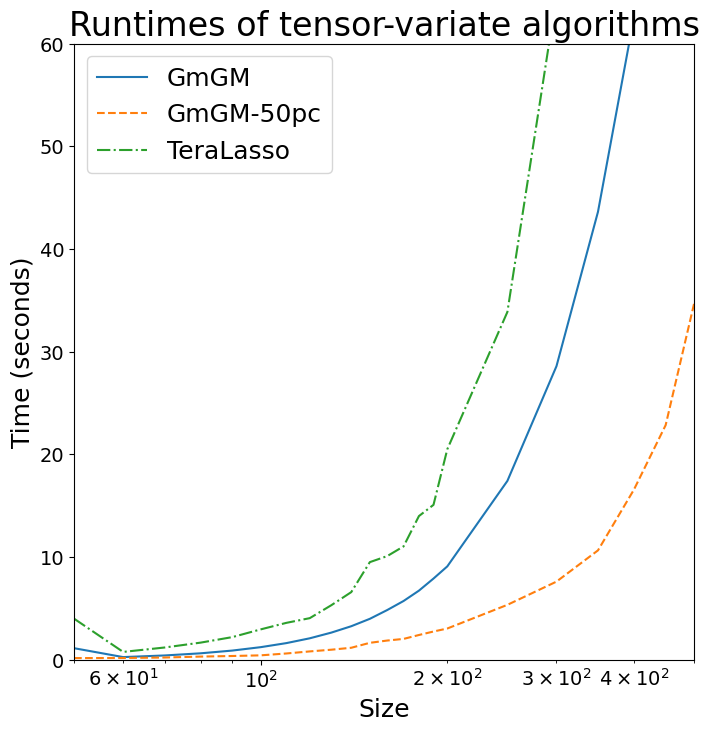

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_3):
    ax.plot(
        size_data_3[:len(timing_data_3[algorithm])],
        timing_data_3[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of tensor-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_3[0], size_data_3[-1]])
ax.set_xscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_3_log.pdf", bbox_inches='tight')

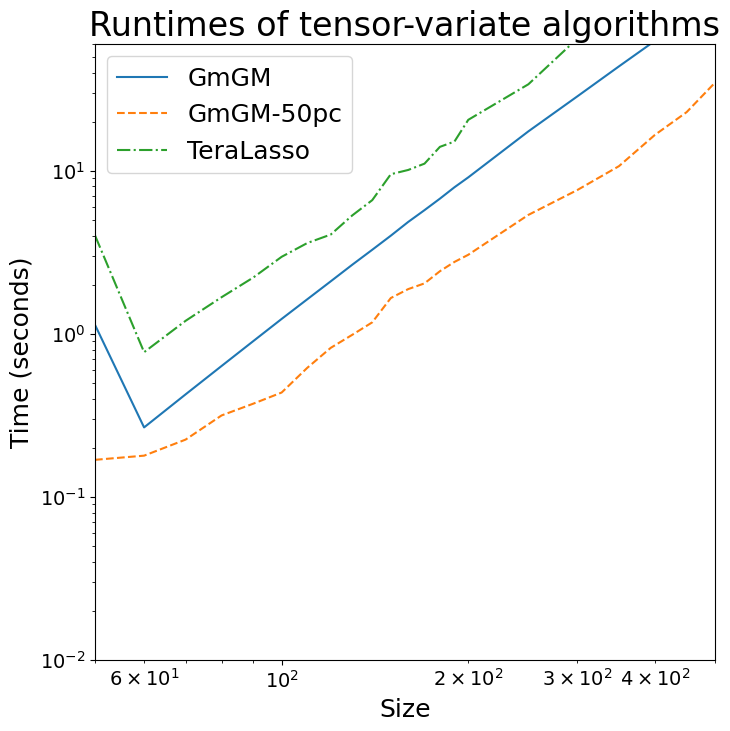

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_3):
    ax.plot(
        size_data_3[:len(timing_data_3[algorithm])],
        timing_data_3[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of tensor-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0.01, 60])
ax.set_xlim([size_data_3[0], size_data_3[-1]])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_3_loglog.pdf", bbox_inches='tight')

## 4-Axis Runtimes

In [15]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
}
size_data_4 = [
    30, 40, 50, 60, 70, 80, 90, 100
]
timing_data_4 = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data_4,
    K=4,
    attempts=1,
    verbose=True
)

Starting (30, 30, 30, 30)
	GmGM: 1.0633508749997418 Seconds
	GmGM-50pc: 0.7289197919999424 Seconds
	TeraLasso: 1.1493669999999838 Seconds
Starting (40, 40, 40, 40)
	GmGM: 1.1832745000001523 Seconds
	GmGM-50pc: 1.9410591249998106 Seconds
	TeraLasso: 3.5171846670000377 Seconds
Starting (50, 50, 50, 50)
	GmGM: 0.6929219999997258 Seconds
	GmGM-50pc: 4.242802582999957 Seconds
	TeraLasso: 9.54252550000001 Seconds
Starting (60, 60, 60, 60)
	GmGM: 1.4368322499999522 Seconds
	GmGM-50pc: 9.948359957999855 Seconds
	TeraLasso: 17.90806662499972 Seconds
Starting (70, 70, 70, 70)
	GmGM: 2.6849568329998874 Seconds
	GmGM-50pc: 16.027710542000023 Seconds
	TeraLasso: 45.40510912499985 Seconds
Starting (80, 80, 80, 80)
	GmGM: 4.6036380840000675 Seconds
	GmGM-50pc: 29.82685979200005 Seconds
TeraLasso ran for longer than 60 seconds
TeraLasso is no longer being tracked
Starting (90, 90, 90, 90)
	GmGM: 7.349096333000034 Seconds
	GmGM-50pc: 54.73435629200003 Seconds
Starting (100, 100, 100, 100)
	GmGM: 11.220

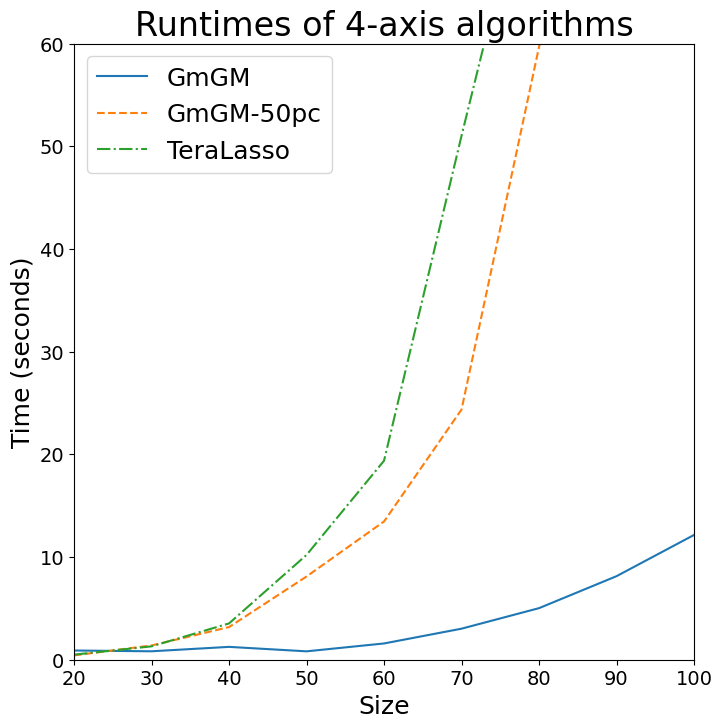

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_4):
    ax.plot(
        size_data_4[:len(timing_data_4[algorithm])],
        timing_data_4[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 4-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_4[0], size_data_4[-1]])
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_4.pdf", bbox_inches='tight')

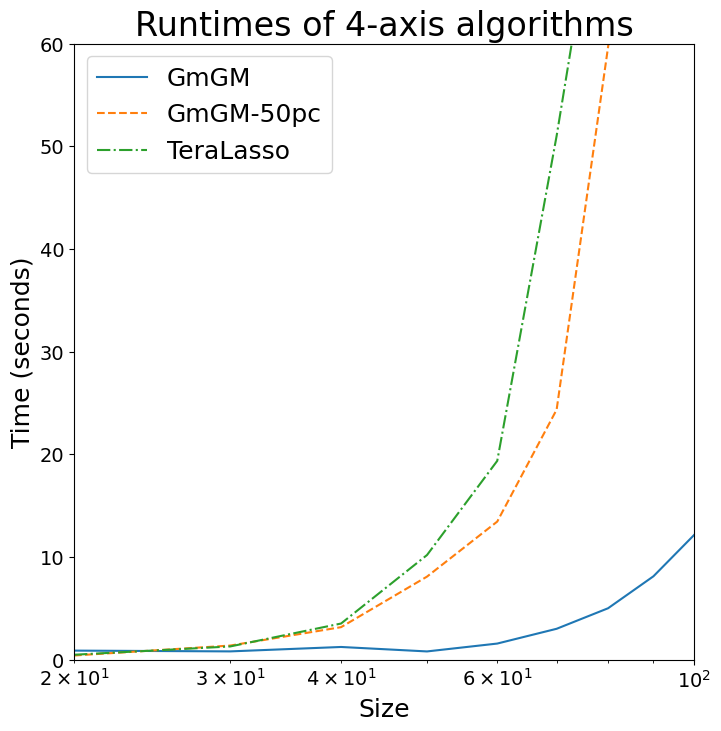

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_4):
    ax.plot(
        size_data_4[:len(timing_data_4[algorithm])],
        timing_data_4[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 4-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_4[0], size_data_4[-1]])
ax.set_xscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_4_log.pdf", bbox_inches='tight')

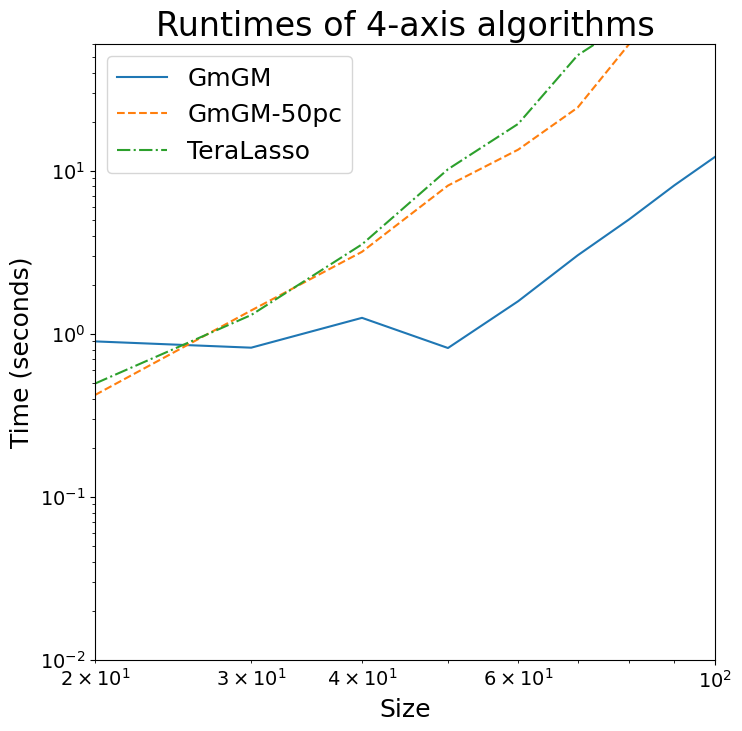

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_4):
    ax.plot(
        size_data_4[:len(timing_data_4[algorithm])],
        timing_data_4[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 4-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0.01, 60])
ax.set_xlim([size_data_4[0], size_data_4[-1]])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_4_loglog.pdf", bbox_inches='tight')